<a href="https://colab.research.google.com/github/ipeirotis/dealing_with_data/blob/master/01-Pandas/A3-Advanced_Data_Manipulation_Techniques.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction to Pandas: Basic Data Manipulation Techniques

## Setup and preliminaries

Install the necessary libraries to connect to MySQL and to read Excel files

In [2]:
!pip3 install -U -q PyMySQL sqlalchemy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.0/45.0 kB 1.5 MB/s eta 0:00:00


In order to read and process files, we are going to use a very powerful, and widely used Python library, called pandas. So, our next step is to import the pandas library in Python, and a few related libraries:

In [3]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

And we type some code to simply change the visual style of the plots. (The code below is optional and not necessary, and for now you do not need to understand what exactly is happening.)

In [4]:
# Render our plots with high resolution
%config InlineBackend.figure_format = 'retina'

In [5]:
# Make the graphs a bit bigger
matplotlib.style.use(["seaborn-v0_8-talk", "seaborn-v0_8-ticks", "seaborn-v0_8-whitegrid"])

## Reading data using SQL from a MySQL Server

We will use a dataset with [restaurant inspection results in NYC](https://data.cityofnewyork.us/Health/DOHMH-New-York-City-Restaurant-Inspection-Results/43nn-pn8j). The dataset that we are going to use has been cleaned up, normalized, and stored in our MySQL database, under the `doh_restaurants` database.

In [6]:
import os
from sqlalchemy import create_engine
from sqlalchemy import text

conn_string = 'mysql+pymysql://{user}:{password}@{host}/{db}?charset=utf8mb4'.format(
    host = 'db.ipeirotis.org',
    user = 'student',
    password = 'dwdstudent2015',
    db = 'doh_restaurants',
    encoding = 'utf8mb4')

engine = create_engine(conn_string)

We fetch the results of the query using the `read_sql` command.

In [7]:
# This query returns back the restaurants in the DOH database
sql = '''
	SELECT R.CAMIS, R.DBA, R.BUILDING, R.STREET, R.ZIPCODE, R.BORO,
          R.CUISINE_DESCRIPTION, R.LATITUDE, R.LONGITUDE, R.NTA
		FROM doh_restaurants.restaurants R
'''

with engine.connect() as connection:
	restaurants = pd.read_sql(text(sql), con=connection)

In [8]:
# This query returns back the results of the inspections of each restaurant
sql = '''
	SELECT R.CAMIS, R.DBA, R.ZIPCODE, R.BORO, R.CUISINE_DESCRIPTION, R.NTA,
				 I.INSPECTION_DATE, I.INSPECTION_ID,
				 I.INSPECTION_TYPE, I.SCORE, I.GRADE
	FROM restaurants R
		JOIN inspections I ON I.CAMIS = R.CAMIS
'''

with engine.connect() as connection:
	inspections = pd.read_sql(text(sql), con=connection)

In [9]:
# This query returns back the results and violations captured in the
# latest inspection of each restaurant
sql = '''
  WITH latest_inspection AS (
		SELECT CAMIS, MAX(INSPECTION_DATE) AS INSPECTION_DATE FROM inspections
		GROUP BY CAMIS
	)
	SELECT R.CAMIS, R.DBA, R.ZIPCODE, R.BORO,
          I.INSPECTION_DATE, I.INSPECTION_ID, I.INSPECTION_TYPE,
          V.VIOLATION_CODE, I.SCORE, I.GRADE
		FROM restaurants R
			JOIN latest_inspection L ON R.CAMIS = L.CAMIS
			JOIN inspections I ON I.CAMIS = L.CAMIS AND L.INSPECTION_DATE = I.INSPECTION_DATE
			JOIN violations V ON I.INSPECTION_ID = V.INSPECTION_ID
'''

with engine.connect() as connection:
	violations = pd.read_sql(text(sql), con=connection)

# Selecting a subset of the columns -- `filter()`

In a dataframe, we can specify the column(s) that we want to keep, and get back another dataframe with just the subset of the columns that we want to keep.

In [ ]:
inspections

In [ ]:
inspections.filter(
    items = ["DBA", "GRADE", "INSPECTION_DATE"]
)

In [ ]:
columns = ["CAMIS", "DBA", "GRADE", "INSPECTION_DATE", "SCORE"]

# Notice the use of "chain notation" below
# Chain notation means putting parentheses around
# the command and then having each operation in its
# own line
(
  inspections
  .filter( items = columns )
  .head(10)
)


We can also use the `like` option to find all the column names that include a certain string. For example, to get all the columns that include the string `DATE`:

In [ ]:
inspections.filter(
    like = 'DATE'
)

We can expand the functionality and also use regular expressions:

In [ ]:
restaurants.filter(
    regex = r'^C' # all the columns that start with C
)

### Exercise

Keep the columns "DBA", "SCORE", "CUISINE DESCRIPTION" and "ZIPCODE" from the `inspections` dataframe.

In [ ]:
# your code here

# Renaming Columns -- `rename()`

To do the equivalent of `SELECT attr AS alias` in Pandas, we use the `rename` command, and pass a dictionary specifying which columns we want to rename:



In [ ]:
restaurants.rename(
    columns = {
      "CAMIS": "RESTID",
      "DBA": "REST_NAME",
      "BUILDING": "STREET_NUM",
      "BORO": "BOROUGH"
    }
)

# Selecting rows -- `query()`

To select rows, we can write basic queries using the `query()` command:

In [ ]:
# Find all violations for restaurants with DBA being Starbucks
restaurants.query(' DBA == "STARBUCKS" ')

In [ ]:
# Find all violations with code 04L (i.e., "has mice")
violations.query(' VIOLATION_CODE == "04L" ')

In [ ]:
# We can store the result in a dataframe called  has_mice
has_mice = violations.query(' VIOLATION_CODE == "04L" ')
has_mice

In [ ]:
# List the most frequent DBA values in the has_mice dataframe
has_mice["DBA"].value_counts().head(20)

In [ ]:
# For comparison, the most frequent DBA names overall across restaurants
restaurants["DBA"].value_counts().head(20)

And we can use more complex conditions.

In [ ]:
has_mice_10012 = (
    violations
    .query('  VIOLATION_CODE == "04L" and ZIPCODE == "10012" ')
    .filter( items = ['DBA', 'INSPECTION_DATE'] )
)

has_mice_10012

...and just to have a bit more fun:

In [ ]:
# all restaurants with mice
mice = has_mice["DBA"].value_counts()
mice.head(5) # show the top-5

In [ ]:
# top-25 most popular restaurant names
topK = 25
top_restaurants = restaurants["DBA"].value_counts().head(topK)
top_restaurants.head(5) # show the top-5

In [ ]:
# Now calculate what % of the top restaurant chains had mice
# The dropna() removes the restaurants that do not appear in top_restaurants
(mice / top_restaurants).dropna()

### Exercise

The following command reads the table `violation_codes`. In addition to the `04L`, check the violation descriptions for the codes `04K`, `04M`, `04N`, and `04O`. Then create an analysis for the restaurants in the area that have these violations.

[This StackOverflow post](https://stackoverflow.com/questions/33990955/combine-pandas-dataframe-query-method-with-isin) explains how to use the `IN` construct with Pandas.

In [ ]:
with engine.connect() as connection:
  sql = "SELECT * FROM doh_restaurants.violation_codes"
  codes = pd.read_sql(text(sql), con=connection)

#### Solution

In [ ]:
filthy_near_NYU = (
    violations
    .query('  VIOLATION_CODE in ["04K", "04L", "04M", "04N", "04O"]  ' )
    .query('  ZIPCODE in ["10012", "10003", "10014"] ')
    .query('  INSPECTION_DATE > "2023-01-01" ')
    .filter( items = ['DBA', 'INSPECTION_DATE'] )
    .sort_values("INSPECTION_DATE", ascending=False)
    .drop_duplicates()
)

filthy_near_NYU.head(20)

# Selecting distinct values -- `drop_duplicates()`

We can do the equivalent of `SELECT DISTINCT` in Pandas by doing the following

In [ ]:
(
    restaurants
    .query(' CUISINE_DESCRIPTION == "Coffee/Tea"  and ZIPCODE == "10012" ')
    .filter( items = ['DBA'])
    .drop_duplicates()
)

# Sorting values -- `sort_values()`

And we can do the equivalent of `ORDER BY` by using the `.sort_values()

In [ ]:
(
    has_mice_10012
    .sort_values("INSPECTION_DATE", ascending=False)
    .head(15)
)

In [ ]:
(
    has_mice_10012
    .sort_values(["INSPECTION_DATE","DBA"], ascending=[False,True])
    .head(15)
)

# Join two tables -- `pd.merge()`

In [ ]:
# Fetch data about population of NYC neighborhoods (NTAs)
nyc_population_url = 'https://data.cityofnewyork.us/api/views/rnsn-acs2/rows.csv?accessType=DOWNLOAD'
nyc_pop = pd.read_csv(nyc_population_url)
nyc_pop

In [ ]:
nyc_pop.columns

In [ ]:
# Change the name of the columns
nyc_pop.columns = ['BOROUGH', 'FIPS_COUNTY', 'NTA_CODE',
       'NTA_NAME', 'POPULATION_2000', 'POPULATION_2010',
       'POP_DIFF_NUMBER', 'POP_DIFF_PCT']

# Drop unnecessary columns
# nyc_pop = nyc_pop.drop(['POPULATION_2000', 'POP_DIFF_NUMBER', 'POP_DIFF_PCT'], axis='columns')

# Dropping lines with empty cell values
nyc_pop = nyc_pop.dropna()

## Merging two dataframes

In [ ]:
merged = pd.merge(
  left = inspections,
  right = nyc_pop,
  left_on = 'NTA',
  right_on = 'NTA_CODE'
)

merged

In [ ]:
# How would you improve the plot below?

merged.plot(
    kind='scatter',
    y = 'SCORE',
    x = 'POPULATION_2010',
    s = 1
)

# Pivot Tables



### Simple pivot tables

[Pivot tables](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.pivot_table.html) is one of the most commonly used exploratory tools, and in Pandas they are extremely flexible.

For example, let's try to examine the average inspection score, broken down by cuisine.

In [11]:
pivot = pd.pivot_table(
    data=inspections,
    index="CUISINE_DESCRIPTION",  # specifies the rows
    values="SCORE",  # specifies the content of the cells
    aggfunc="mean",  # we calculate the average/mean score
)

In [ ]:
# The full pivot table
pivot

<Axes: ylabel='CUISINE_DESCRIPTION'>

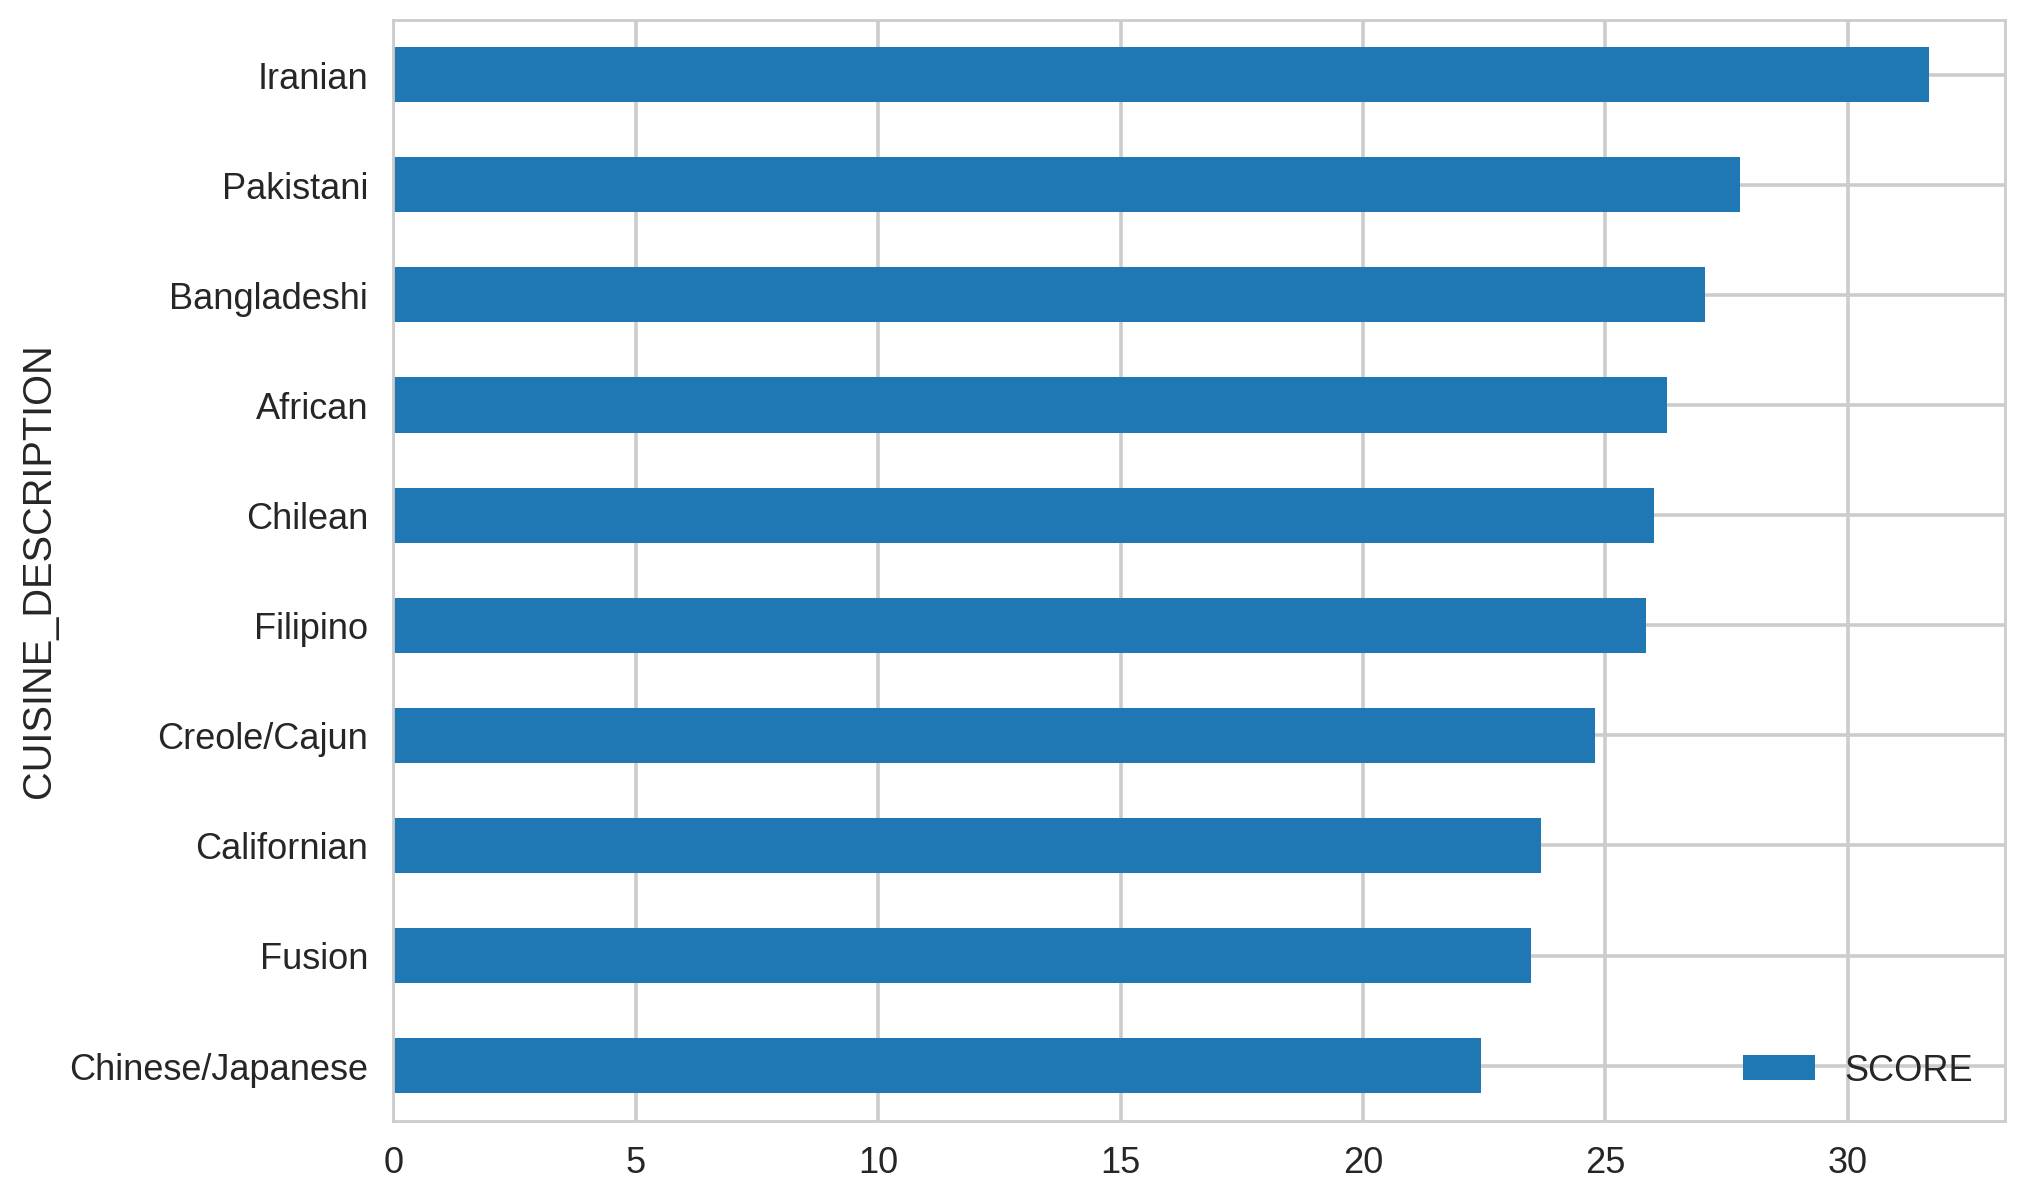

In [19]:
# Plotting the scores of the 10 highest cuisines
pivot.sort_values('SCORE').tail(10).plot(kind='barh')

In [ ]:
# Count the number of CAMIS values that appear on each date
pivot = pd.pivot_table(
    data=inspections,
    index="INSPECTION_DATE",  # specifies the rows
    values="CAMIS",  # specifies the content of the cells
    aggfunc="count",  # we ask to count how many different CAMIS values we see
)

In [ ]:
pivot

Now, let's plot this. By default, Pandas considers the "index" column to be the x-axis, and plots the rest.

In [ ]:
pivot.plot()

In [ ]:
# We keep the last 100 entries and plot
pivot.tail(100).plot()

### Exercise

Now let's do an exercise,  instead of counting the number of inspections, we want to compute the average score assigned by the inspectors. Hint: We will need to change the `values` and the `aggfunc` parameters in the `pivot_table` function above.

In [ ]:
# your code here

#### Solution

In [ ]:
pivot = pd.pivot_table(
    data=inspections,
    index="INSPECTION_DATE",  # specifies the rows
    values="SCORE",  # specifies the content of the cells
    aggfunc="mean",  # compute the average SCORE
)

In [ ]:
pivot.plot(figsize=(10, 4))

### Changing date granularity

We can also use the [resample](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.resample.html) command to change the frequency from one day, to, say, 7 days. Then we can compute, say, the average (`mean()`) for these days, or the total number (`sum()`) of inspections.

In [ ]:
pivot = pd.pivot_table(
    data=inspections,
    index="INSPECTION_DATE",  # specifies the rows
    values="CAMIS",  # specifies the content of the cells
    aggfunc="count",  # we ask to count how many different CAMIS values we see
)

pivot.resample("1W").sum()

Now, let's plot this. By default, Pandas considers the "index" column to be the x-axis, and plots the rest.

In [ ]:
# Plot the average number of inspections, over 7-day periods
pivot.resample("1W").sum().plot()

In [ ]:
# Plot the total number of inspections, over 1-month periods
pivot.resample("1M").sum().plot()

In [ ]:
plot = pivot.resample("7D").mean().plot()
plot.set_xlabel("Date of Inspection")
plot.set_ylabel("Average Number of Inspections (over a 7-day period)")
plot.set_title("Analysis of Number of Inspections over Time")

### Pivot Table with two (or more) variables

We would like to break down the results by borough, so we add the `column` parameter.

In [ ]:
# Show grades broken down by borough
pivot2 = pd.pivot_table(
    data=inspections,  #
    index="GRADE",
    columns="BORO",
    values="CAMIS",
    aggfunc="count"
)
pivot2

In [ ]:
# By default, the "index" becomes the x-axis and we plot all numeric columns
pivot2.plot(kind='bar')

#### Normalization

In [ ]:
# Let's say that we want to normalize the values
# to account for the different number of inspections
# in each borough
pivot2.sum()

In [ ]:
# This command normalizes each column, by dividing with its sum:
pivot2 / pivot2.sum()

In [ ]:
normalized_by_borough = pivot2 / pivot2.sum()

# Percent of inspections per borough with a given grade
normalized_by_borough.plot(kind='bar')

#### Normalization and Transpose

In [ ]:
# This takes the transpose of the dataframe
pivot2.T

In [ ]:
# Plotting the transpose now uses the boroughs as the "x" axis
pivot2.T.plot(kind='barh')

In [ ]:
# Variation,
pivot2.T.plot(kind='barh', stacked=True)

In [ ]:
normalized_by_borough.T.plot(kind='barh', stacked=True).legend(frameon=True)



### Exercise

We now want to examine if different cuisines have different inspection scores. Compute the average inspection score by cuisine. Use the `sort_values()` command ([documentation](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.sort_values.html)) to order cuisines by their inspection scores. Analyze further by breaking down the score over inspection dates, and plot.

#### Solution

In [ ]:
pivot = pd.pivot_table(
    data=inspections,
    index="INSPECTION_DATE",  # dates are the rows
    columns="CUISINE_DESCRIPTION",  # cuisines are the columns
    values="SCORE",  # we analyze the SCORE
    aggfunc="mean",  # compute the average SCORE
)
# Select 3 columns (american, frenchn, chinese), compute the average score for a month
# and plot the results
pivot[["American", "French", "Chinese"]].resample("1M").mean().plot(figsize=(10, 4))

# Defining new columns -- `assign()` and `apply()`



### Using the `assign()` approach

The `assign` command applies a function to a dataframe and returns back a new dataframe with the new column(s).

In [ ]:
# We define functions that take as input a dataframe df
# and return back a new column.

# This function combines STREET/BUILDING/BORO/ZIPCODE columns into one address
#
def combine_address(df):
  return (df.BUILDING + ' ' + df.STREET + ', ' + df.BORO + ', NY ' + df.ZIPCODE).str.upper()


# This function computes the distance (in miles) from NYU,
# given the lat/lon of the other location
#
def distance(df):
  NYU_lon = -73.9962293
  NYU_lat = 40.7291527
  # The calculation below is simply the Pythagorean theorem.
  # The normalizing values "0.0146" and "0.0196"
  # are just for converting lat/lon differences to miles
  distance = ((df['LATITUDE']-NYU_lat)/0.0146)**2 + ((df['LONGITUDE']-NYU_lon)/0.0196)**2
  return np.sqrt(distance)



In [ ]:
# We now use the `assign` function to create two new columns
# using the logic in the functions above,
(
  restaurants
  .assign(
      distance_from_NYU = distance,
      address = combine_address
  )
  .filter(items = ['DBA','address','distance_from_NYU'])
)

In [ ]:
# And let's eliminate now duplicates and sort by distance
(
  restaurants
  .assign(
      distance_from_NYU = distance,
      address = combine_address
  )
  .filter(items = ['DBA','address','distance_from_NYU'])
  .query('distance_from_NYU > 0') # eliminates NaN values from distance_from_NYU
  .drop_duplicates()
  .sort_values('distance_from_NYU')
  .head(25)
)

### Using the `apply` approach

The `apply` function allow the users to pass a function and apply it on every single row or column of a Pandas datarame.

In [ ]:
!sudo pip3 install -q -U geopy

from geopy import distance

# A bit more accurate distance calculation, which returns back
# the distance in miles. However, we cannot pass a dataframe
# to the function but only individual values
def distance_from_NYU_geodesic(row):
  NYU_lon = -73.9962293
  NYU_lat = 40.7291527
  NYU = (NYU_lat, NYU_lon)
  rest = (row.LATITUDE, row.LONGITUDE)
  #if pd.isnull(row.Latitude) or pd.isnull(row.Longitude):
  #  return None
  return distance.distance(NYU, rest).miles


In [ ]:
# We now create a smaller version of the dataset with just
# the names/address/lon/lat of the restaurants
rest_names_locations = (
    restaurants
    .assign(
      address = combine_address
    )
    .filter(items = ['CAMIS','DBA','address','LONGITUDE', 'LATITUDE'])
    .query(' LONGITUDE==LONGITUDE ') # idiomatic expression for saying IS NOT NULL
    .query(' LATITUDE==LATITUDE ') # idiomatic expression for saying IS NOT NULL
    .drop_duplicates()
)

rest_names_locations

In [ ]:
# We will now apply the function distance_from_NYU_geodesic
# to every row of the dataset:
rest_names_locations.apply(distance_from_NYU_geodesic, axis='columns')


In [ ]:
# We will now save the result into a new column
rest_names_locations['distance_from_NYU']=rest_names_locations.apply(distance_from_NYU_geodesic, axis='columns')

In [ ]:
# Let's see how many restaurants are within half a mile from NYU :)
(
    rest_names_locations
    .query('distance_from_NYU < 0.5')
    .sort_values('distance_from_NYU')
)

# Aggregation functions -- `agg()`

In [ ]:
inspections['SCORE'].agg('mean')

In [ ]:
inspections['SCORE'].agg(['mean','std','count','nunique'])

In [ ]:
inspections.agg(
    {
        'SCORE': ['mean','std','count','nunique'],
        'CAMIS':  ['nunique','count']
    }
)

In [ ]:
inspections.agg(
        num_scored_violations = ('SCORE', 'count'),
        mean_score = ('SCORE', 'mean'),
        std_score  = ('SCORE', 'std'),
        num_entries = ('CAMIS',  'count'),
        num_restaurants = ('CAMIS',  'nunique'),
  )

# Calculating aggregates per groups -- `groupby()`

In [ ]:
inspections.groupby('INSPECTION_DATE').agg({'SCORE': 'mean'})

In [ ]:
(
  inspections
  .groupby('INSPECTION_DATE')
  .agg(
    score_mean = ('SCORE', 'mean'), # calculate the mean of the score
    graded_restaurants = ('CAMIS', 'nunique') # count unique restaurant IDs
  )
  .tail(20) # show the last 20 lines
)

In [ ]:
(
  inspections
  .groupby('INSPECTION_DATE')
  .agg(
    score_mean = ('SCORE', 'mean'), # calculate the aveage score for the date
    graded_restaurants = ('CAMIS', 'nunique') # and the number of restaurants
  )
  .query('graded_restaurants>10') # keep only days with at least 10 graded restauranta
  .filter(items=['score_mean']) # we only want to plot the score
  .plot()
)

In [ ]:
(
  inspections
  .groupby('INSPECTION_DATE')
  .agg(
    score_mean = ('SCORE', 'mean'), # calculate the aveage score for the date
    graded_restaurants = ('CAMIS', 'nunique') # and the number of restaurants
  )
  .query('graded_restaurants>10') # keep only days with at least 10 graded restauranta
  .filter(items=['score_mean']) # we only want to plot the score
  .resample('1M').mean() # change the frequency to 1 month, and show avg score per month
  .plot(
    style='--o', # use a dotted line and circles as markers
    linewidth=2, # the line should be 1 pixel wide
    markersize=8, # the marker size set to 8
  )
)

## Advanced Pivot Tables

We can also add multiple attributes in the index and columns. It is also possible to have multiple aggregation functions, and we can even define our own aggregation functions.

In [ ]:
# We break down by BORO and GRADE, and also calculate
# inspections scores
pivot_advanced = pd.pivot_table(
    data=violations,  #
    index="INSPECTION_DATE",
    columns=["BORO", "GRADE"],
    values="SCORE",
    aggfunc=["mean", "std"],
)

# Take the total number of inspections (unique and non-unique)
agg = pivot_advanced.resample("1M").mean()

# Show the last 5 entries and show the transpose (.T)
agg.tail().T

In [ ]:
# your code here